# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import RobustScaler

from xgboost import plot_importance

import warnings
warnings.filterwarnings(action='ignore')



c:\Users\aryij\anaconda3\envs\football\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 경로
path = "data/df_eda.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,player_name,start_season,goals,assists,minutes_played,competition_code,date_of_birth,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
0,Aaron Connolly,2019,3,2,1261,premier-league,2000-01-28,20,Centre-Forward,Brighton and Hove Albion Football Club,4000000.0,Ireland,right,174.0
1,Aaron Connolly,2020,2,1,791,premier-league,2000-01-28,21,Centre-Forward,Brighton and Hove Albion Football Club,7000000.0,Ireland,right,174.0
2,Aaron Connolly,2021,0,0,155,premier-league,2000-01-28,22,Centre-Forward,Brighton and Hove Albion Football Club,6000000.0,Ireland,right,174.0
3,Aaron Cresswell,2019,3,0,2730,premier-league,1989-12-15,30,Left-Back,West Ham United Football Club,6500000.0,England,left,170.0
4,Aaron Cresswell,2020,0,8,3172,premier-league,1989-12-15,31,Left-Back,West Ham United Football Club,5000000.0,England,left,170.0


In [4]:
# date_of_birth 열 제거 (age로 대체)
df = df.drop("date_of_birth", axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   goals                    16001 non-null  int64  
 3   assists                  16001 non-null  int64  
 4   minutes_played           16001 non-null  int64  
 5   competition_code         16001 non-null  object 
 6   age                      16001 non-null  int64  
 7   position                 16001 non-null  object 
 8   current_club_name        16001 non-null  object 
 9   market_value_per_season  16001 non-null  float64
 10  country                  16001 non-null  object 
 11  foot                     16001 non-null  object 
 12  height_in_cm             16001 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.6+ MB


In [6]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [7]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['start_season', 'goals', 'assists', 'minutes_played', 'age', 'market_value_per_season', 'height_in_cm']
범주형 변수 : ['player_name', 'competition_code', 'position', 'current_club_name', 'country', 'foot']


## 데이터 분리

In [8]:
# target 컬럼 "market_value_per_season"
target = "market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((13081, 13), (2920, 13))

In [9]:
# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [10]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10464, 12), (10464,), (2617, 12), (2617,), (2920, 12), (2920,))

In [11]:
num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# train 데이터 copy
X_train_no_enc = train[features].copy()
# y_train_no_enc = train[target].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()
# y_val_no_enc = val[target].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()
# y_test_no_enc = test[target].copy()

## 인코딩

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [12]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## Baseline 모델 생성

In [13]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [14]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  386343605.76726747
Coefficients:


[('player_name', 0.5971008144368535),
 ('start_season', -191915.37147877135),
 ('goals', 668332.4470516932),
 ('assists', 602710.2604357428),
 ('minutes_played', 1781.5603715125126),
 ('competition_code', 0.16389622705901274),
 ('age', -269504.2039484474),
 ('position', 0.11295741385947622),
 ('current_club_name', 0.4047648209379986),
 ('country', 0.01590084934650804),
 ('foot', -0.3091807192477347),
 ('height_in_cm', 21342.052850126453)]

In [16]:
# def rmsle(y, pred):
#     log_y = np.log1p(y)
#     log_pred = np.log1p(pred)
#     squared_error = (log_y-log_pred)**2
#     rmsle = np.sqrt(np.mean(squared_error))
#     return rmsle

In [17]:
def get_rmsle(y_actual, y_pred):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()                 
    return np.sqrt(mean_error)   

In [18]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)
    y_test_pred_lr = model.predict(X_test)

    # Baseline 모델의 MAE, MSE, RMSE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
    # base_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lr))
    base_rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr, squared=False)
    # base_rootMeanSqLogErr = metrics.root_mean_squared_log_error(y_test, y_test_pred_lr)
    base_rootMeanSqLogErr = get_rmsle(y_test, y_test_pred_lr)
    # base_rootMeanSqLogErr2 = get_rmsle(y_test, y_test_pred_lr)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "RMSLE" : '{:.2f}'.format(base_rootMeanSqLogErr),
                            #  "RMSLE2" : '{:.2f}'.format(base_rootMeanSqLogErr2),
                             "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [19]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Linear Regression,5377046.29,94974396502650.03,9745480.82,0.96,0.65


## 스케일링
- 데이터셋의 다양한 컬럼들에 이상치 다수 존재
    - 하지만 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라진다
    - 따라서 이상치 제거하지 않음
- `RobustScaler` 선택 (이상치의 영향 최소화)
- References
    - https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
    - IQR = Q3 - Q1 : 25퍼센타일과 75퍼센타일의 값들
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다

In [20]:
# RobustScaler X_train 데이터셋에 fit
robustScaler = RobustScaler().fit(X_train)

# RobustScaler로 X_train, X_val, X_test 데이터셋 변환
X_train_robust = robustScaler.transform(X_train)
X_val_robust = robustScaler.transform(X_val)
X_test_robust = robustScaler.transform(X_test)

In [21]:
# num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# # catboost 사용하기 위한 scaling 따로 실시 (별도의 encoding 거치지 않고 스케일링)

# robustScaler_no_enc = RobustScaler().fit(X_train_no_enc[num_cols])

# # RobustScaler로 X_train_no_enc, X_val_no_enc, X_test_no_enc 데이터셋 변환
# X_train_robust_no_enc = robustScaler_no_enc.transform(X_train_no_enc[num_cols])
# X_val_robust_no_enc = robustScaler_no_enc.transform(X_val_no_enc[num_cols])
# X_test_robust_no_enc = robustScaler_no_enc.transform(X_test_no_enc[num_cols])

## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [22]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [23]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [24]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        model.fit(X_train_robust, y_train)

        # Robust Scaling 거친 train 데이터를 바탕으로 예측
        y_train_pred = model.predict(X_train_robust)
        y_val_pred = model.predict(X_val_robust)
        y_test_pred = model.predict(X_test_robust)

        # 모델의 MAE, MSE, RMSE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
        meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
        # rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
        rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
        # rootMeanSqLogErr = metrics.root_mean_squared_log_error(y_test, y_test_pred)
        rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)
        # rootMeanSqLogErr2 = get_rmsle(y_test, y_test_pred)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                # "RMSLE2" : '{:.2f}'.format(rootMeanSqLogErr2),
                                "R2 Score" : '{:.2f}'.format(model.score(X_test_robust, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["R2 Score", "RMSLE", "RMSE"], ascending=[False, True, True]).reset_index(drop=True)



In [25]:
# Top 3 : CatBoost, LightGBM, XGBoost순으로 R2 Score 높다
model_list(models)
    

Learning rate set to 0.059332
0:	learn: 13542164.5452625	total: 136ms	remaining: 2m 15s
1:	learn: 13060068.9690653	total: 139ms	remaining: 1m 9s
2:	learn: 12594305.6539795	total: 142ms	remaining: 47.1s
3:	learn: 12156909.1294200	total: 144ms	remaining: 35.9s
4:	learn: 11769254.3948585	total: 147ms	remaining: 29.2s
5:	learn: 11388533.9581510	total: 149ms	remaining: 24.8s
6:	learn: 11038010.7336579	total: 152ms	remaining: 21.6s
7:	learn: 10710202.9369521	total: 155ms	remaining: 19.2s
8:	learn: 10405659.7562356	total: 157ms	remaining: 17.3s
9:	learn: 10139099.0382793	total: 160ms	remaining: 15.8s
10:	learn: 9876423.4548581	total: 162ms	remaining: 14.6s
11:	learn: 9638984.7230995	total: 165ms	remaining: 13.6s
12:	learn: 9390530.8605334	total: 168ms	remaining: 12.7s
13:	learn: 9171234.1265569	total: 170ms	remaining: 12s
14:	learn: 8974119.3568818	total: 173ms	remaining: 11.4s
15:	learn: 8784723.0530824	total: 176ms	remaining: 10.8s
16:	learn: 8602248.3990244	total: 178ms	remaining: 10.3s
17

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,LightGBM,4010021.87,71398731879862.64,8449777.03,0.70,0.74
1,CatBoost,3973861.68,69728072444490.88,8350333.67,0.71,0.74
2,XGBoost,4160607.05,72243166041700.36,8499597.99,0.77,0.73
3,Random Forest,4181484.93,81843966431806.52,9046765.52,0.65,0.70
4,Linear Regression,5377046.29,94974396501445.17,9745480.82,0.96,0.65
5,Decision Tree,5543082.19,121458255565068.50,11020810.11,0.94,0.55


In [26]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models):
    models_results = []

    for model_name, model in models:

        if model_name == "CatBoost":

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 생성 및 훈련
            model.fit(X_train_no_enc, y_train, cat_features=cat_features)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)
            y_test_pred_cat = model.predict(X_test_no_enc)

            # 모델의 MAE, MSE, RMSE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_test, y_test_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat)
            # rootMeanSqErr_cat = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_cat))
            rootMeanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat, squared=False)
            # rootMeanSqLogErr_cat = metrics.root_mean_squared_log_error(y_test, y_test_pred_cat)
            rootMeanSqLogErr_cat = get_rmsle(y_test, y_test_pred_cat)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test_no_enc, y_test))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            # Robust Scaling 거친 train 데이터를 바탕으로 예측
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

            # 모델의 MAE, MSE, RMSE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
            meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
            # rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
            rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
            # rootMeanSqLogErr = metrics.root_mean_squared_log_error(y_test, y_test_pred)
            rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models before Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["R2 Score", "RMSLE", "RMSE"], ascending=[False, True, True]).reset_index(drop=True)

In [27]:
model_list2(models[3:])

Learning rate set to 0.059332
0:	learn: 13653696.6051392	total: 71.1ms	remaining: 1m 11s
1:	learn: 13289911.9578542	total: 167ms	remaining: 1m 23s
2:	learn: 12974497.2540124	total: 253ms	remaining: 1m 23s
3:	learn: 12664524.7075041	total: 334ms	remaining: 1m 23s
4:	learn: 12381771.8118006	total: 420ms	remaining: 1m 23s
5:	learn: 12110808.3301324	total: 503ms	remaining: 1m 23s
6:	learn: 11857426.9500235	total: 590ms	remaining: 1m 23s
7:	learn: 11614183.0093664	total: 673ms	remaining: 1m 23s
8:	learn: 11410700.5592546	total: 755ms	remaining: 1m 23s
9:	learn: 11187253.5307023	total: 848ms	remaining: 1m 23s
10:	learn: 10977126.3796601	total: 928ms	remaining: 1m 23s
11:	learn: 10794053.4259314	total: 1.01s	remaining: 1m 23s
12:	learn: 10632607.2516437	total: 1.09s	remaining: 1m 22s
13:	learn: 10463427.2507392	total: 1.17s	remaining: 1m 22s
14:	learn: 10314079.3497962	total: 1.25s	remaining: 1m 22s
15:	learn: 10166125.8591156	total: 1.34s	remaining: 1m 22s
16:	learn: 10041279.0114318	total: 

31:	learn: 8774443.5992419	total: 3.01s	remaining: 1m 31s
32:	learn: 8727834.9785342	total: 3.1s	remaining: 1m 30s
33:	learn: 8683280.2685476	total: 3.18s	remaining: 1m 30s
34:	learn: 8644906.6549226	total: 3.27s	remaining: 1m 30s
35:	learn: 8608200.3947121	total: 3.36s	remaining: 1m 29s
36:	learn: 8567701.2554767	total: 3.44s	remaining: 1m 29s
37:	learn: 8537392.5133757	total: 3.53s	remaining: 1m 29s
38:	learn: 8500606.1697410	total: 3.6s	remaining: 1m 28s
39:	learn: 8472546.7672833	total: 3.67s	remaining: 1m 28s
40:	learn: 8444634.2335662	total: 3.74s	remaining: 1m 27s
41:	learn: 8408767.0379337	total: 3.81s	remaining: 1m 27s
42:	learn: 8384625.2074020	total: 3.89s	remaining: 1m 26s
43:	learn: 8365397.1323783	total: 3.96s	remaining: 1m 26s
44:	learn: 8342457.4340749	total: 4.03s	remaining: 1m 25s
45:	learn: 8319581.9351298	total: 4.11s	remaining: 1m 25s
46:	learn: 8296880.3785256	total: 4.18s	remaining: 1m 24s
47:	learn: 8271366.2850005	total: 4.25s	remaining: 1m 24s
48:	learn: 82534

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,LightGBM,4035437.43,72248947974888.20,8499938.12,0.74,0.73
1,XGBoost,4160337.96,72239648004902.25,8499391.04,0.77,0.73
2,CatBoost,4599038.41,85747317567412.42,9259984.75,0.84,0.68


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거친 데이터셋으로 진행(`model_list` 함수)한 `CatBoost`가 더 높은 `R2 Score` 기록

    - **0.75 vs 0.68** (Target Encoding 실행한 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- R2 Score가 높은 `CatBoost`, `LightGBM`, `XGBoost` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 R2 Score보다 높다 (0.65)

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


#### `CatBoost`

In [28]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [29]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_robust, y_train)
    # predictions = model.predict(X_val_robust)
    # rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    predictions = model.predict(X_test_robust)
    # rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    # rmsle = metrics.root_mean_squared_log_error(y_test, predictions)
    rmsle = get_rmsle(y_test, predictions)


    return rmsle

In [30]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-03 09:19:07,651] A new study created in memory with name: no-name-362512b5-5508-489f-b645-996ac990f1f0
[I 2024-04-03 09:19:13,340] Trial 0 finished with value: 0.7154059586137635 and parameters: {'n_estimators': 1811, 'learning_rate': 0.07969454818643935, 'depth': 8, 'subsample': 0.6187255599871848, 'colsample_bylevel': 0.19821770842031466, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.7154059586137635.
[I 2024-04-03 09:19:14,606] Trial 1 finished with value: 0.828560007884092 and parameters: {'n_estimators': 703, 'learning_rate': 0.05399484409787434, 'depth': 7, 'subsample': 0.7226689489062432, 'colsample_bylevel': 0.06955526958101232, 'min_data_in_leaf': 97}. Best is trial 0 with value: 0.7154059586137635.
[I 2024-04-03 09:19:18,517] Trial 2 finished with value: 0.8387225567323714 and parameters: {'n_estimators': 3414, 'learning_rate': 0.0026587543983272706, 'depth': 2, 'subsample': 0.22423428436076215, 'colsample_bylevel': 0.3390301308115608, 'min_data_in_leaf': 

In [31]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2907, 'learning_rate': 0.016427182662370712, 'depth': 9, 'subsample': 0.34619574575079914, 'colsample_bylevel': 0.4812914285399674, 'min_data_in_leaf': 90}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.670965325308175


In [32]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [33]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [34]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list([("CatBoost_tuned", cat_optuna)])

0:	learn: 13898828.8301874	total: 14.1ms	remaining: 41s
1:	learn: 13761908.2615220	total: 23.2ms	remaining: 33.7s
2:	learn: 13626581.7966602	total: 34.6ms	remaining: 33.5s
3:	learn: 13501899.8928421	total: 43.8ms	remaining: 31.8s
4:	learn: 13365878.9788595	total: 52.5ms	remaining: 30.5s
5:	learn: 13231808.7701220	total: 64.4ms	remaining: 31.1s
6:	learn: 13101318.8213353	total: 73.5ms	remaining: 30.4s
7:	learn: 12969832.6960924	total: 80.5ms	remaining: 29.2s
8:	learn: 12845270.8861127	total: 89ms	remaining: 28.7s
9:	learn: 12731121.5871280	total: 96.2ms	remaining: 27.9s
10:	learn: 12612523.8037858	total: 103ms	remaining: 27.2s
11:	learn: 12491220.9021299	total: 109ms	remaining: 26.2s
12:	learn: 12369819.6496427	total: 116ms	remaining: 25.7s
13:	learn: 12258659.3075980	total: 122ms	remaining: 25.2s
14:	learn: 12139090.8088537	total: 129ms	remaining: 24.9s
15:	learn: 12022031.9482877	total: 136ms	remaining: 24.6s
16:	learn: 11910805.4361602	total: 143ms	remaining: 24.4s
17:	learn: 1179965

102:	learn: 7055600.3838632	total: 844ms	remaining: 23s
103:	learn: 7032835.0242388	total: 851ms	remaining: 22.9s
104:	learn: 7008153.4756285	total: 859ms	remaining: 22.9s
105:	learn: 6984214.0981025	total: 867ms	remaining: 22.9s
106:	learn: 6962496.0007896	total: 878ms	remaining: 23s
107:	learn: 6940173.1071247	total: 887ms	remaining: 23s
108:	learn: 6918455.5454649	total: 894ms	remaining: 22.9s
109:	learn: 6898565.9624348	total: 903ms	remaining: 23s
110:	learn: 6873583.8914546	total: 910ms	remaining: 22.9s
111:	learn: 6850747.3288208	total: 918ms	remaining: 22.9s
112:	learn: 6828700.5558011	total: 927ms	remaining: 22.9s
113:	learn: 6807593.3091802	total: 936ms	remaining: 22.9s
114:	learn: 6784134.7992311	total: 943ms	remaining: 22.9s
115:	learn: 6765796.2980668	total: 950ms	remaining: 22.9s
116:	learn: 6746781.3228811	total: 958ms	remaining: 22.8s
117:	learn: 6726017.8887410	total: 966ms	remaining: 22.8s
118:	learn: 6704417.0749072	total: 974ms	remaining: 22.8s
119:	learn: 6686850.89

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,CatBoost_tuned,3949071.57,72529273944546.62,8516412.03,0.69,0.73


#### `XGBoost`

In [35]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        # "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        # "max_depth": trial.suggest_int("max_depth", 8, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train, verbose=False)
    predictions = model.predict(X_test_robust)
    # rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    # rmsle = metrics.root_mean_squared_log_error(y_test, predictions)
    rmsle = get_rmsle(y_test, predictions)


    return rmsle

In [36]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-03 09:27:31,025] A new study created in memory with name: no-name-6bf0b602-6293-4803-acee-e024fde2e396


[I 2024-04-03 09:27:37,424] Trial 0 finished with value: 0.796793549845235 and parameters: {'n_estimators': 1860, 'learning_rate': 0.003488976654890368, 'max_depth': 9, 'subsample': 0.3889156603589098, 'colsample_bytree': 0.3168877842030117, 'min_child_weight': 11}. Best is trial 0 with value: 0.796793549845235.
[I 2024-04-03 09:27:38,218] Trial 1 finished with value: 0.836377473896199 and parameters: {'n_estimators': 993, 'learning_rate': 0.040215545266902894, 'max_depth': 1, 'subsample': 0.9875425897704915, 'colsample_bytree': 0.7836325308318246, 'min_child_weight': 4}. Best is trial 0 with value: 0.796793549845235.
[I 2024-04-03 09:27:40,379] Trial 2 finished with value: 0.6895929413185121 and parameters: {'n_estimators': 519, 'learning_rate': 0.04274869455295218, 'max_depth': 8, 'subsample': 0.742556809638938, 'colsample_bytree': 0.7827068293516485, 'min_child_weight': 2}. Best is trial 2 with value: 0.6895929413185121.
[I 2024-04-03 09:27:47,417] Trial 3 finished with value: 0.753

In [37]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 918, 'learning_rate': 0.006077484069934721, 'max_depth': 10, 'subsample': 0.8949424915076419, 'colsample_bytree': 0.8373294951864462, 'min_child_weight': 5}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6230275149996394


In [38]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [39]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [40]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list([("XGBoost_tuned", xgb_optuna)])


====== Models Before Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,XGBoost_tuned,4025997.89,77668073453262.06,8812949.19,0.62,0.71


#### `LightGBM`

In [41]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        # "n_estimators": 1000,
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train)
    predictions = model.predict(X_test_robust)
    # rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    # rmsle = metrics.root_mean_squared_log_error(y_test, predictions)
    rmsle = get_rmsle(y_test, predictions)


    return rmsle

In [42]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-03 09:30:15,799] A new study created in memory with name: no-name-3853f42f-89fa-4acb-8687-3daae63f3c8d


[I 2024-04-03 09:30:18,473] Trial 0 finished with value: 0.967186179062658 and parameters: {'n_estimators': 3326, 'learning_rate': 0.06197015748809146, 'num_leaves': 327, 'subsample': 0.15454932830129292, 'colsample_bytree': 0.2665384044148446, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.967186179062658.
[I 2024-04-03 09:30:19,862] Trial 1 finished with value: 0.7839814406368462 and parameters: {'n_estimators': 3363, 'learning_rate': 0.05265761277157429, 'num_leaves': 9, 'subsample': 0.5352099374486874, 'colsample_bytree': 0.44654045299134, 'min_data_in_leaf': 23}. Best is trial 1 with value: 0.7839814406368462.
[I 2024-04-03 09:30:21,039] Trial 2 finished with value: 0.6919108733105945 and parameters: {'n_estimators': 919, 'learning_rate': 0.0047340227734041914, 'num_leaves': 966, 'subsample': 0.35704278541971746, 'colsample_bytree': 0.5428510906561977, 'min_data_in_leaf': 71}. Best is trial 2 with value: 0.6919108733105945.
[I 2024-04-03 09:30:24,184] Trial 3 finished with

In [43]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3560, 'learning_rate': 0.0013674611103915398, 'num_leaves': 920, 'subsample': 0.5700770391865846, 'colsample_bytree': 0.8933043311096593, 'min_data_in_leaf': 35}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6229581465859954


In [44]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [45]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [46]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list([("LightGBM_tuned", lgbm_optuna)])

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 10464, number of used features: 12
[LightGBM] [Info] Start training from score 8983092.029817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,LightGBM_tuned,4001234.52,74762597073637.77,8646536.71,0.64,0.72


#### 튜닝한 모델들 비교

In [47]:
models_tuned = models = [
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgbm_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [48]:
model_list(models_tuned, "After")

0:	learn: 13898828.8301874	total: 8.39ms	remaining: 24.4s
1:	learn: 13761908.2615220	total: 17.2ms	remaining: 24.9s
2:	learn: 13626581.7966602	total: 26.8ms	remaining: 26s
3:	learn: 13501899.8928421	total: 35.7ms	remaining: 25.9s
4:	learn: 13365878.9788595	total: 52.4ms	remaining: 30.4s
5:	learn: 13231808.7701220	total: 63.4ms	remaining: 30.7s
6:	learn: 13101318.8213353	total: 71.8ms	remaining: 29.8s
7:	learn: 12969832.6960924	total: 80.8ms	remaining: 29.3s
8:	learn: 12845270.8861127	total: 89ms	remaining: 28.6s
9:	learn: 12731121.5871280	total: 97.8ms	remaining: 28.3s
10:	learn: 12612523.8037858	total: 106ms	remaining: 27.9s
11:	learn: 12491220.9021299	total: 114ms	remaining: 27.5s
12:	learn: 12369819.6496427	total: 121ms	remaining: 27s
13:	learn: 12258659.3075980	total: 127ms	remaining: 26.3s
14:	learn: 12139090.8088537	total: 135ms	remaining: 26s
15:	learn: 12022031.9482877	total: 143ms	remaining: 25.9s
16:	learn: 11910805.4361602	total: 151ms	remaining: 25.7s
17:	learn: 11799658.36

118:	learn: 6704417.0749072	total: 955ms	remaining: 22.4s
119:	learn: 6686850.8925514	total: 963ms	remaining: 22.4s
120:	learn: 6669679.5969494	total: 973ms	remaining: 22.4s
121:	learn: 6649646.2275828	total: 979ms	remaining: 22.3s
122:	learn: 6632962.4711288	total: 985ms	remaining: 22.3s
123:	learn: 6613212.6830819	total: 993ms	remaining: 22.3s
124:	learn: 6594822.7881706	total: 1s	remaining: 22.3s
125:	learn: 6578993.5904330	total: 1.01s	remaining: 22.2s
126:	learn: 6562275.4273370	total: 1.02s	remaining: 22.2s
127:	learn: 6541790.8204671	total: 1.03s	remaining: 22.4s
128:	learn: 6525066.4490337	total: 1.04s	remaining: 22.4s
129:	learn: 6506548.7494331	total: 1.05s	remaining: 22.4s
130:	learn: 6488759.3939714	total: 1.05s	remaining: 22.3s
131:	learn: 6472011.9799832	total: 1.06s	remaining: 22.3s
132:	learn: 6455199.7193941	total: 1.07s	remaining: 22.3s
133:	learn: 6439346.9290986	total: 1.07s	remaining: 22.3s
134:	learn: 6425583.2146173	total: 1.08s	remaining: 22.2s
135:	learn: 64095

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,CatBoost_tuned,3949071.57,72529273944546.62,8516412.03,0.69,0.73
1,LightGBM_tuned,4001234.52,74762597073637.77,8646536.71,0.64,0.72
2,XGBoost_tuned,4025997.89,77668073453262.06,8812949.19,0.62,0.71


In [49]:
best_params_cat = {'n_estimators': 2907, 
                   'learning_rate': 0.016427182662370712, 
                   'depth': 9, 
                   'subsample': 0.34619574575079914, 
                   'colsample_bylevel': 0.4812914285399674, 
                   'min_data_in_leaf': 90}

best_params_xgb = {'n_estimators': 918, 
                   'learning_rate': 0.006077484069934721, 
                   'max_depth': 10, 
                   'subsample': 0.8949424915076419, 
                   'colsample_bytree': 0.8373294951864462, 
                   'min_child_weight': 5}

best_params_lgbm = {'n_estimators': 3560, 
                    'learning_rate': 0.0013674611103915398, 
                    'num_leaves': 920, 
                    'subsample': 0.5700770391865846, 
                    'colsample_bytree': 0.8933043311096593, 
                    'min_data_in_leaf': 35}

In [50]:
# XGBoost 모델 생성
model_xgb = XGBRegressor(n_estimators=1000,
                          learning_rate=0.2,
                          min_child_weight=100,
                          max_depth=3,
                          gamma=100,
                          colsample_bytree=0.5,
                          random_state=42)

# Robust 스케일링 적용한 X_train_scaled 이용
model_xgb.fit(X_train_robust, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=100, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=100, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

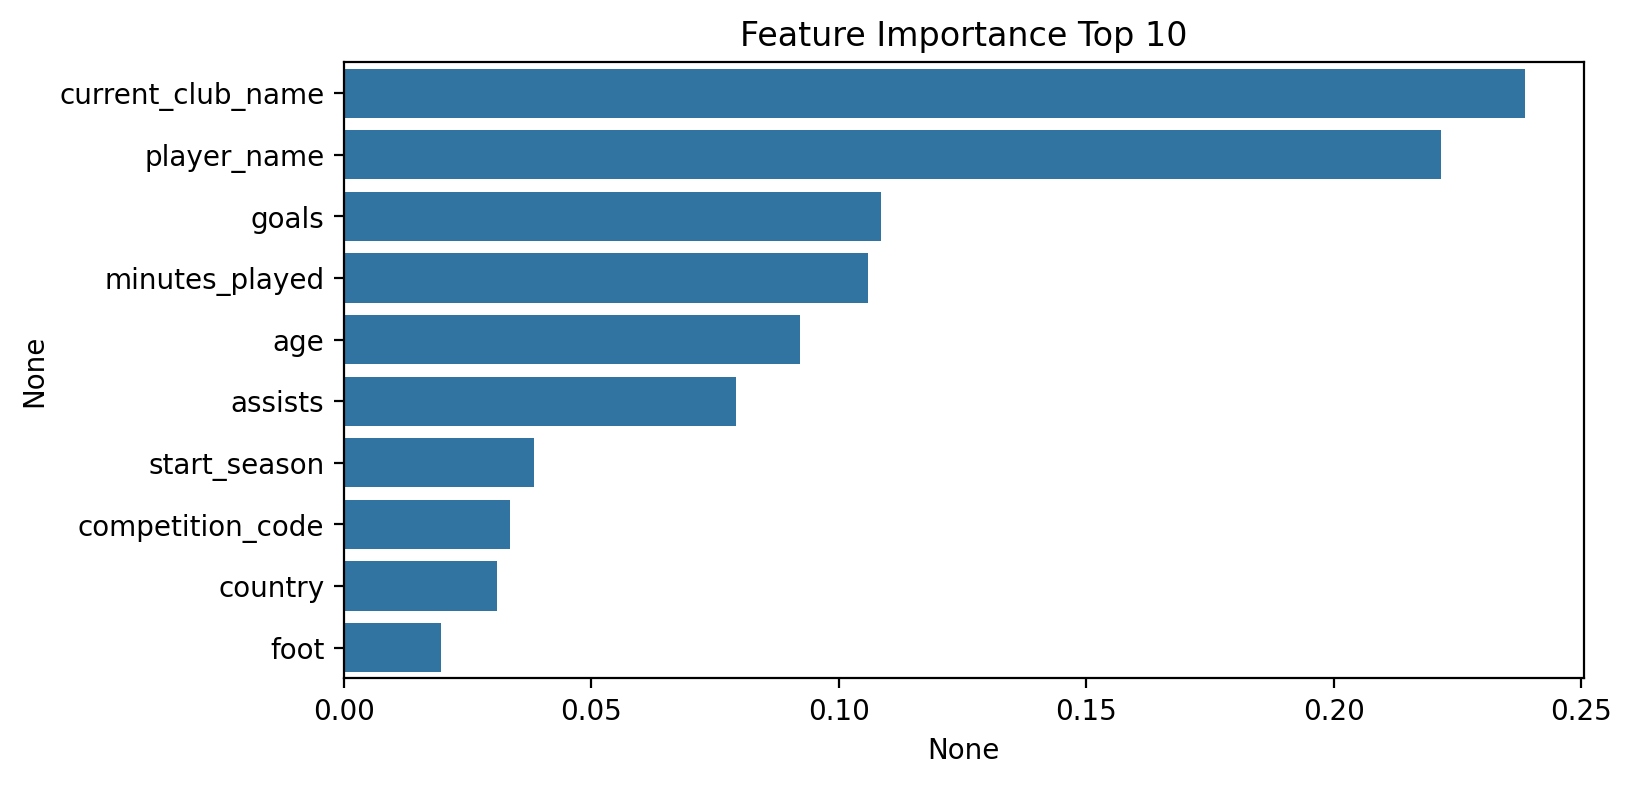

In [51]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = model_xgb.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [52]:
model_xgb.score(X_train_robust, y_train)

0.9056581916327883

In [53]:
model_xgb.score(X_val_robust, y_val)

0.7728344674668755

In [54]:
model_xgb.score(X_test_robust, y_test)

0.7377671314026153

In [55]:
model_xgb.predict(X_test_robust)

array([-7.2904894e+05,  1.7518922e+07,  1.5986185e+07, ...,
        1.1956536e+06,  2.3963475e+04,  2.5655368e+07], dtype=float32)

In [56]:
metrics.mean_squared_error(y_test, model_xgb.predict(X_test_robust), squared=False)

8433543.830826035

In [57]:
# 1446
# Kai Havertz
model_xgb.predict(X_test_robust)[1446]

72254850.0

In [58]:
y_test

7          900000.0
11       30000000.0
21       28000000.0
26       15000000.0
27         500000.0
            ...    
15983     5000000.0
15988     1800000.0
15994     1000000.0
15995     1000000.0
16000    18000000.0
Name: market_value_per_season, Length: 2920, dtype: float64

In [59]:
X_test

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7,3.090621e+06,2023,0,0,235,1.760686e+07,34,7.573533e+06,1.669718e+07,1.580558e+07,9.059222e+06,170.0
11,1.378455e+07,2023,0,0,720,1.760686e+07,21,6.410489e+06,1.246267e+07,1.165922e+07,8.371419e+06,185.0
21,1.869467e+07,2023,0,0,540,1.760686e+07,25,5.777534e+06,3.253681e+07,1.580558e+07,8.982164e+06,190.0
26,6.612677e+06,2023,0,0,526,1.760686e+07,21,1.040246e+07,4.469679e+06,1.580558e+07,8.982164e+06,181.0
27,8.983092e+06,2023,1,0,298,9.004052e+06,28,9.240542e+06,1.740985e+06,8.238751e+06,9.059222e+06,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15983,4.012582e+06,2023,1,0,2093,9.404664e+06,29,9.814288e+06,3.976935e+06,7.964127e+06,8.982164e+06,177.0
15988,2.202918e+06,2023,1,4,1664,9.404664e+06,34,6.410489e+06,8.704671e+06,7.964127e+06,8.982164e+06,182.0
15994,9.018411e+05,2023,0,0,1170,9.404664e+06,33,5.777534e+06,1.168214e+07,1.263018e+07,8.982164e+06,192.0
15995,8.983092e+06,2023,1,0,366,2.712768e+06,22,1.059005e+07,9.386958e+05,6.922201e+06,9.059222e+06,170.0


In [60]:
y_test[y_test == 55000000.0]

1760     55000000.0
3380     55000000.0
7842     55000000.0
8596     55000000.0
8752     55000000.0
9670     55000000.0
10023    55000000.0
10024    55000000.0
14431    55000000.0
15091    55000000.0
Name: market_value_per_season, dtype: float64

In [61]:
y_test.reset_index()

,index,market_value_per_season
0,7,900000.0
1,11,30000000.0
2,21,28000000.0
3,26,15000000.0
4,27,500000.0
...,...,...
2915,15983,5000000.0
2916,15988,1800000.0
2917,15994,1000000.0
2918,15995,1000000.0


In [62]:
y_test.reset_index()[y_test.reset_index()["index"]==7842]

,index,market_value_per_season
1446,7842,55000000.0


In [63]:
df[df.player_name=="Kai Havertz"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
7838,Kai Havertz,2019,12,6,2463,bundesliga,20,Attacking Midfield,Arsenal Football Club,81000000.0,Germany,left,193.0
7839,Kai Havertz,2020,4,5,1520,premier-league,21,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7840,Kai Havertz,2021,8,4,1811,premier-league,22,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7841,Kai Havertz,2022,7,1,2579,premier-league,23,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0
7842,Kai Havertz,2023,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0


In [64]:
test[features][test[features].player_name=="Kai Havertz"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7842,Kai Havertz,2023,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,Germany,left,193.0
